<a href="https://colab.research.google.com/github/rohanbojja/Colab/blob/master/03_01_%E2%80%93_Julia_on_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [1]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

--2020-04-04 08:01:45--  https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.0-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.4/julia-1.4.0-linux-x86_64.tar.gz [following]
--2020-04-04 08:01:46--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.4/julia-1.4.0-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98969249 (94M) [application/x-gzip]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[===================

# The actual code

In [14]:
import Pkg; Pkg.add("CSVFiles")
Pkg.add("MLJ")
Pkg.add("DataFrames")
Pkg.add("PrettyPrinting")
Pkg.add("MLJModels")
Pkg.add("DecisionTree")
Pkg.add("XGBoost")
Pkg.add("Plots")
using Base
using CSVFiles
using DataFrames
using Plots
using MLJ
using Statistics
using PrettyPrinting

train_data = DataFrame(CSVFiles.load("train.csv"))
test_data = DataFrame(CSVFiles.load("test.csv"))
tstart = size(train_data,1)

aug = vcat(select(train_data,Not(:SalePrice)),test_data[:,:]) # For combined stats
df = aug
println(size(df))

df = coerce(df,autotype(df,:discrete_to_continuous))
df[!,:LotFrontage] = coalesce.(df[!,:LotFrontage],mean(skipmissing(df.LotFrontage)))
df[!,:MasVnrArea] = coalesce.(df[!,:MasVnrArea],mean(skipmissing(df.MasVnrArea)))
df[!,:BsmtFinSF1] = coalesce.(df[!,:BsmtFinSF1],mean(skipmissing(df.BsmtFinSF1)))
df[!,:BsmtFinSF2] = coalesce.(df[!,:BsmtFinSF2],mean(skipmissing(df.BsmtFinSF2)))
df[!,:TotalBsmtSF] = coalesce.(df[!,:TotalBsmtSF],mean(skipmissing(df.TotalBsmtSF)))
df[!,:BsmtFullBath] = coalesce.(df[!,:BsmtFullBath],mean(skipmissing(df.BsmtFullBath)))
df[!,:BsmtHalfBath] = coalesce.(df[!,:BsmtHalfBath],mean(skipmissing(df.BsmtHalfBath)))
df[!,:GarageYrBlt] = coalesce.(df[!,:GarageYrBlt],mean(skipmissing(df.GarageYrBlt)))
df[!,:GarageCars] = coalesce.(df[!,:GarageCars],mean(skipmissing(df.GarageCars)))
df[!,:GarageArea] = coalesce.(df[!,:GarageArea],mean(skipmissing(df.GarageArea)))
df[!,:BsmtUnfSF] = coalesce.(df[!,:BsmtUnfSF],mean(skipmissing(df.BsmtUnfSF)))
df = coerce(df,autotype(df,:few_to_finite))
aug=df

df = aug[1:tstart,:]
insertcols!(df,1,SalePrice=train_data[:,:SalePrice])
df = coerce(df,autotype(df,:discrete_to_continuous))

df2 = aug[tstart+1:end,:]

schema(df2)

selectedcols = [:SalePrice,:Id,:LotFrontage,:LotArea,:YearBuilt,:MasVnrArea,:BsmtFinSF1,:BsmtFinSF2,:BsmtUnfSF,:TotalBsmtSF,Symbol("1stFlrSF"),Symbol("2ndFlrSF"),:GrLivArea,:GarageYrBlt,:GarageArea,:WoodDeckSF,:OpenPorchSF,:EnclosedPorch,:ScreenPorch]
# selectedcols = [Symbol("1stFlrSF"),Symbol("2ndFlrSF"),:SalePrice,:Id,:MSSubClass,:LotFrontage,:LotArea,:OverallQual,:OverallCond,:YearBuilt,:YearRemodAdd,:MasVnrArea,:BsmtFinSF1,:BsmtFinSF2,:BsmtUnfSF,:TotalBsmtSF,:LowQualFinSF,:GrLivArea,:BsmtFullBath,:BsmtHalfBath,:FullBath,:HalfBath,:BedroomAbvGr,:KitchenAbvGr,:TotRmsAbvGrd,:Fireplaces,:GarageYrBlt,:GarageCars,:GarageArea,:WoodDeckSF,:OpenPorchSF,:EnclosedPorch,Symbol("3SsnPorch"),:ScreenPorch,:PoolArea,:MiscVal,:MoSold,:YrSold]
df = df[:,selectedcols]
schema(df)


@load XGBoostRegressor verbosity = 0
@load DecisionTreeRegressor

tY, tX = unpack(df, ==(:SalePrice ), !=([:SalePrice,:Id]))

"XG" |> pprintln
xg = XGBoostRegressor()
mach_xg = machine(xg, tX, tY)
evaluate!(mach_xg, resampling=Holdout(fraction_train=0.7),
          measure=mae) |> pprintln

# "DTR" |> pprintln
# dtr = DecisionTreeRegressor()
# mach_dtr = machine(dtr, tX, tY)
# evaluate!(mach_dtr, resampling=Holdout(fraction_train=0.7),
#           measure=mae) |> pprintln

# "Tuned XG" |> pprintln
# r = range(xg, :max_depth, lower=1, upper=5)
# tm = TunedModel(model=xg, ranges=[r,], measure=mae)
# mach_xg_t = machine(tm, tX, tY)
# MLJ.fit!(mach_xg_t)
# evaluate!(mach_xg_t, resampling=Holdout(fraction_train=0.7),
#           measure=mae) |> pprintln

# "Tuned DTR" |> pprintln
# r = range(dtr, :max_depth, lower=1, upper=1000)
# tm = TunedModel(model=dtr, ranges=[r,], measure=mae)
# mach_dtr_t = machine(tm, tX, tY)
# MLJ.fit!(mach_dtr_t)
# evaluate!(mach_dtr_t, resampling=Holdout(fraction_train=0.7),
#           measure=mae) |> pprintln
# fitted_params(mach_dtr_t).best_model

"Tuned XG ensemble" |> pprintln
em1 = EnsembleModel(atom=xg,n=10)
r1 = range(em1, :(atom.max_depth), lower=1, upper=5)
r2 = range(em1, :bagging_fraction, lower=0.4, upper=1.0)
tem1 = TunedModel(model=em1,tuning=Grid(resolution=12), ranges=[r1, r2], measure=mae)
mach_tem1 = machine(tem1,tX,tY)
MLJ.fit!(mach_tem1)
evaluate!(mach_tem1, resampling=Holdout(fraction_train=0.7),
          measure=mae) |> pprintln


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`


(2919, 80)


┌ Info: A model type "XGBoostRegressor" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /root/.julia/packages/MLJModels/gHake/src/loading.jl:43
┌ Info: A model type "DecisionTreeRegressor" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /root/.julia/packages/MLJModels/gHake/src/loading.jl:43


"XG"
(measure = [mae],
 measurement = [23012.774266909248],
 per_fold = [[23012.774266909248]],
 per_observation = [missing])
"Tuned XG ensemble"


┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @ 5…36.
└ @ MLJBase /root/.julia/packages/MLJBase/ESDzL/src/machines.jl:182
┌ Info: Attempting to evaluate 60 models.
└ @ MLJTuning /root/.julia/packages/MLJTuning/VVra9/src/tuned_models.jl:362


(measure = [mae],
 measurement = [21130.945593428958],
 per_fold = [[21130.945593428958]],
 per_observation = [missing])


(5,)
(12,)
(60,)


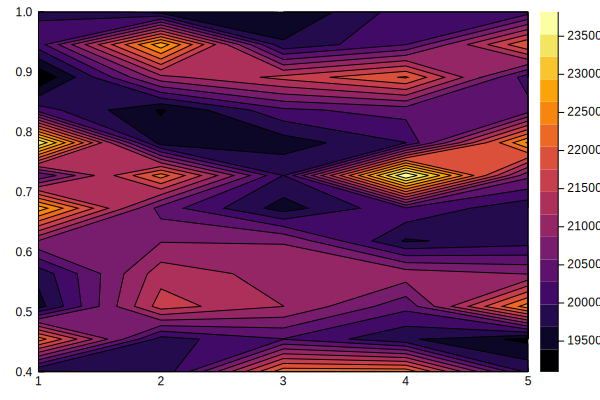

In [29]:
r = report(mach_tem1)
res = r.plotting
vals_sf = res.parameter_values[:, 1]
vals_bf = res.parameter_values[:, 2]
xa = vals_sf
ya = vals_bf
za = res.measurements
 size(sort(unique(xa))) |> pprintln
 size(sort(unique(ya))) |> pprintln
 size(za) |> pprintln
p1 = Plots.contour(sort(unique(xa)), sort(unique(ya)),za, fill =true)
#Plots.plot(p1)